In [30]:
%load_ext autoreload
import numpy as np
import functools
%aimport FE
%aimport common_meshes
import matplotlib.pyplot as plt
import triangle
import pandas as pd
import matplotlib.cm as cm
%matplotlib inline
print(plt.style.available)
plt.style.use('seaborn-paper')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['seaborn-deep', 'seaborn-bright', 'seaborn-darkgrid', 'seaborn-poster', 'dark_background', 'ggplot', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-dark', 'bmh', 'seaborn-whitegrid', 'seaborn-paper', 'fivethirtyeight', 'classic', 'grayscale', 'seaborn-notebook', 'seaborn-colorblind', 'seaborn-muted', 'seaborn-white', 'seaborn-ticks', 'seaborn-pastel']


#Some helper functions

In [2]:
def cartesian_product(arrays):
    broadcastable = np.ix_(*arrays)
    broadcasted = np.broadcast_arrays(*broadcastable)
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    out = np.empty(rows * cols, dtype=broadcasted[0].dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

In [5]:
def is_in_ellipse(L, W, lam, pt):
    x,y = pt
    return int((x*np.pi/L)**2 + (y*np.pi/W)**2 < lam)

def count(L, W, lam, dirichlet):
    """Compute the eigenvalue counting function of a rectangle"""
    # if dirichlet, start all counting ranges at 1. otherwise, start at 0.
    start = int(dirichlet)
    max_x = np.floor(L*np.sqrt(lam)/np.pi)
    max_y = np.floor(W*np.sqrt(lam)/np.pi)
    x = np.arange(start, max_x+1, 1)
    y = np.arange(start, max_y+1, 1)
    grid = cartesian_product([x,y])
    def test(pt):
        return is_in_ellipse(L, W, lam, pt)
    if not list(grid):
        return 0
    else:
        return np.sum(np.apply_along_axis(test, 1, grid))

count(5, 3, 10, True)

7

#We will consider a 1x1 square
#Let us compute its first 10 Neumann eigenvalues:

In [65]:
first_eigenvalues = np.array(
    sorted([(np.pi*m/1.)**2 + (np.pi*n/1.)**2 for m in range(10) for n in range(25)])[:25]
)

In [43]:
print(first_eigenvalues)

[   0.            9.8696044     9.8696044    19.7392088    39.4784176
   39.4784176    49.34802201   49.34802201   78.95683521   88.82643961
   88.82643961   98.69604401   98.69604401  128.30485721  128.30485721]


#Now we create meshes ...

In [78]:
skeleton = {"vertices": np.array([[0., 0.], [1., 0.], [1., 1.], [0., 1.]]),
            "segments": np.array([[0, 1], [1, 2], [2, 3], [3, 0]])}
meshes = {}
fineness = ["0.00005", "0.00007", "0.0001", "0.0005"]
for a in fineness:
    meshes[str(a)] = triangle.triangulate(skeleton, 'pqa'+str(a))

In [79]:
%%time
eigvals = {}
for a in fineness:
    eigvals[str(a)] = FE.findEigs(meshes[str(a)], 25)[0]

CPU times: user 13min 32s, sys: 20.3 s, total: 13min 53s
Wall time: 3min 56s


In [80]:
eigval_array = np.array([first_eigenvalues] + [eigvals[str(a)] for a in fineness]).T
eigval_df = pd.DataFrame(eigval_array, columns=["ground_truth"] + [str(a) for a in fineness])

In [81]:
eigval_df

,ground_truth,0.00005,0.00007,0.0001,0.0005
0,0.000000,1.045617e-12,7.328131e-13,3.660388e-13,4.935809e-14
1,9.869604,9.870181e+00,9.870406e+00,9.870750e+00,9.875250e+00
2,9.869604,9.870183e+00,9.870413e+00,9.870752e+00,9.875441e+00
3,19.739209,1.974151e+01,1.974246e+01,1.974381e+01,1.976285e+01
4,39.478418,3.948761e+01,3.949133e+01,3.949660e+01,3.956765e+01
5,39.478418,3.948767e+01,3.949147e+01,3.949669e+01,3.957239e+01
6,49.348022,4.936246e+01,4.936817e+01,4.937681e+01,4.949213e+01
7,49.348022,4.936254e+01,4.936859e+01,4.937688e+01,4.949861e+01
8,78.956835,7.899369e+01,7.900878e+01,7.903063e+01,7.933349e+01
9,88.826440,8.887297e+01,8.889147e+01,8.891910e+01,8.928215e+01


[ 0.267004  0.004874  0.329415  1.      ]
[ 0.229739  0.322361  0.545706  1.      ]
[ 0.127568  0.566949  0.550556  1.      ]
[ 0.369214  0.788888  0.382914  1.      ]
[ 0.993248  0.906157  0.143936  1.      ]


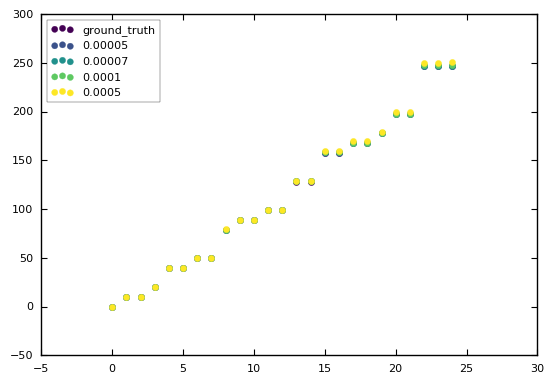

In [82]:
colors = cm.viridis(np.linspace(0, 1, len(fineness)+1))
for y, c in zip(eigval_df.columns, colors):
    print(c)
    plt.scatter(eigval_df.index, eigval_df[y], label=y, color=c)
plt.legend(loc='upper left')
plt.show()

[ 0.267004  0.004874  0.329415  1.      ]
[ 0.229739  0.322361  0.545706  1.      ]
[ 0.127568  0.566949  0.550556  1.      ]
[ 0.369214  0.788888  0.382914  1.      ]
[ 0.993248  0.906157  0.143936  1.      ]


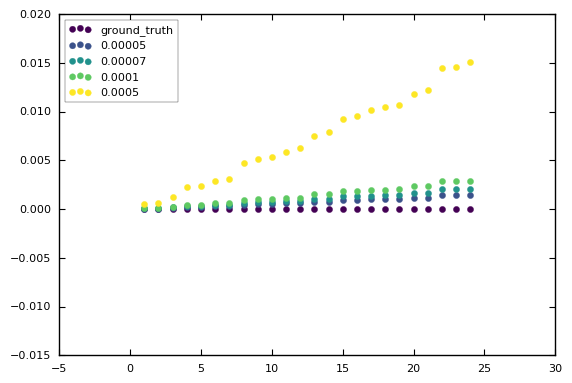

In [83]:
colors = cm.viridis(np.linspace(0, 1, len(fineness)+1))
for y, c in zip(eigval_df.columns, colors):
    print(c)
    plt.scatter(eigval_df.index, (eigval_df[y] - eigval_df["ground_truth"])/eigval_df["ground_truth"],
                label=y, color=c)
plt.legend(loc='upper left')
plt.show()